In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, Dataset 
import matplotlib.dates as mdates
import json

In [ ]:
!pip install transformers==4.5.1

     |████████████████████████████████| 2.1 MB 15.6 MB/s 
     |████████████████████████████████| 895 kB 62.4 MB/s 
     |████████████████████████████████| 3.3 MB 59.4 MB/s 


In [ ]:
pip install -U sentence-transformers  #安裝sentence-transformers

     |████████████████████████████████| 78 kB 6.5 MB/s 
     |████████████████████████████████| 3.1 MB 33.1 MB/s 
     |████████████████████████████████| 1.2 MB 54.0 MB/s 
     |████████████████████████████████| 59 kB 8.8 MB/s 
     |████████████████████████████████| 596 kB 69.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=ded827ef73e8288c1f21534d43d3e77498b4941abe1b11590ef4f1e07944aff0
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: transformers
    Found existing installation: transformers 4.5.1
    Uninstalling transformers-4.5.1:
      Successfully uninstalled transformers-4.5.1


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device)) 

Using cuda device


In [ ]:
# 使用顯卡型號
# K80 < P4 < T4 < P100 <= T4(fp16) < V100
!nvidia-smi

Wed Nov 10 06:34:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    30W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 載入資料


In [ ]:
import os
print('Downloading dataset...')
!gdown --id '1I7OVDW-Sy8yL00V4zWlqFOhCMemqEe0I' --output bert_test.xlsx


Downloading...
From: https://drive.google.com/uc?id=1I7OVDW-Sy8yL00V4zWlqFOhCMemqEe0I
To: /content/bert_test.xlsx
100% 47.5k/47.5k [00:00<00:00, 37.8MB/s]


In [ ]:
import pandas as pd
df = pd.read_excel("bert_test.xlsx", header=None, names=['sentence_source', 'sentence', 'label'])
df

,sentence_source,sentence,label
0,1970,毛主席语录 我们的方针要放在什么基点上？放在自己力量的基点上，叫做自力更生。,0
1,1970,命没有克服不了的困难 ——吉林市油脂厂自力更生、艰苦创业的调查报告 《红旗》杂志...,0
2,1970,思想教育工程技术人员 上海无线电十四厂革委会组织工人对工程技术人员进行再教育，不断提高...,0
3,1970,以北京六厂二校为榜样 认真落实党对知识分子的政策 据新华社南京电南京浦镇车辆厂革...,1
4,1970,一切积极因素”的教导 充分发挥革命技术人员的作用 据新华社合肥电安徽省蚌埠柴油机...,1
5,1970,七十年代的战斗日子里 ——大庆石油工人新年生产又创新成绩 无限忠于伟大领袖毛主席...,1
6,1970,寨贫下中农的革命精神大破“地区落后论” 淮阴专区连续四年夺得农业大丰收 实现了粮...,2
7,1970,身，穷水窝变成粮棉仓 新五公社自力更生、艰苦奋斗，把一万五千多亩泖田改造成良田，夺得粮...,2
8,1970,发扬敢想敢干革命精神 席庄生产队创造先进植棉法 新华社郑州电河南省泌阳县陈庄公社...,2
9,1970,油加工机械化半机械化 山东省文登县革委会带领全县人民坚决贯彻执行毛主席的“备战、备荒、...,2


In [ ]:

# 列印資料集的記錄數
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# 抽樣10條資料來預覽一下
df.sample(10)


Number of training sentences: 21



,sentence_source,sentence,label
15,1970,调查研究掌握规律争取主动 河南省获嘉县生产资料供应站革命领导小组 伟大领...,4
0,1970,毛主席语录 我们的方针要放在什么基点上？放在自己力量的基点上，叫做自力更生。,0
3,1970,以北京六厂二校为榜样 认真落实党对知识分子的政策 据新华社南京电南京浦镇车辆厂革...,1
18,1970,元旦社论号召日本人民 掀起更大的反对美日反动派的风暴 帝国主义就是战争，必须用革...,5
6,1970,寨贫下中农的革命精神大破“地区落后论” 淮阴专区连续四年夺得农业大丰收 实现了粮...,2
14,1970,想指导，就能创造奇迹 广州铁路南站工人学哲学小组 “巧妇难为无米之炊”，这句成语...,4
4,1970,一切积极因素”的教导 充分发挥革命技术人员的作用 据新华社合肥电安徽省蚌埠柴油机...,1
8,1970,发扬敢想敢干革命精神 席庄生产队创造先进植棉法 新华社郑州电河南省泌阳县陈庄公社...,2
12,1970,和民兵正在平整岗地。本报通讯员摄,3
7,1970,身，穷水窝变成粮棉仓 新五公社自力更生、艰苦奋斗，把一万五千多亩泖田改造成良田，夺得粮...,2


In [ ]:
# df.loc[df.label == 0].sample(5)[['sentence', 'label']]
# 我們把 sentence 和 label 欄位載入到 numpy 陣列中
sentences = df.sentence.values
labels = df.label.values


# BERT 分詞器
要將文字輸入到 BERT 中，必須先對它們分詞，並使用模型內部提供的詞彙表，把這些詞轉換為詞的下標。

先在程式碼中匯入 BERT 庫，這裡使用 "uncased" 小寫版本的預訓練模型：

In [ ]:
from transformers import BertTokenizer

# 載入 BERT 分詞器
print('Loading BERT tokenizer...')

PRETRAINED_MODEL_NAME = "bert-base-chinese"  # 指定繁簡中文 BERT-BASE 預訓練模型

tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)


Loading BERT tokenizer...


Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

我們輸入一個句子試試：

In [ ]:
# 輸出原始句子
print('Original: ', sentences[1])

# 將分詞後的內容輸出
print('Tokenized: ', tokenizer.tokenize(sentences[1]))

# 將每個詞對映到詞典下標
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[1])))


Original:  命没有克服不了的困难    ——吉林市油脂厂自力更生、艰苦创业的调查报告    《红旗》杂志编者按：吉林市油脂厂的事迹，是一曲自力更生、艰苦奋斗、勤俭办工厂的壮丽的赞歌。从这里，人们可以看到用毛泽东思想武装起来的伟大的中国人民无穷无尽的创造力量。毛主席指出：“社会的财富是工人、农民和劳动知识分子自己创造的。只要这些人掌握了自己的命运，又有一条马克思列宁主义的路线，不是回避问题，而是用积极的态度去解决问题，任何人间的困难总是可以解决的。”这就是我们胜利的源泉，这就是我们前进的方向。    吉林市油脂厂是迎着大跃进的浩荡东风诞生的。共产党员、特等残废军人刘声带领十二名烈军属和街道居民，凑了二十五元资金，三口大锅闹革命，办起了一个朝气蓬勃、欣欣向荣的社会主义企业。    伟大领袖毛主席教导说：“我们的方针要放在什么基点上？放在自己力量的基点上，叫做自力更生。”这个厂的革命群众，全心全意听毛主席的话，按毛主席的指示办事，自力更生，艰苦创业，为革命而生产，用革命精神搞生产。在这里，艰难险阻、困难挫折都不在话下，洋奴哲学、爬行主义全站不住脚。    工人们说：为革命没有克服不了的困难，为革命没有吃不了的辛苦，为革命没有满足的时候。在无产阶级文化大革命中，他们彻底批判了叛徒、内奸、工贼刘少奇的反革命修正主义路线，使毛主席关于“独立自主、自力更生”的伟大思想，在全厂革命群众中深深地扎下了根。    他们依靠工人阶级的革命精神的优势，使工厂的面貌发生了根本的变化。这个厂现有二百一十八人，已由生产单一品种发展到能够生产七十多种不同规格的产品，由炼废油到成批生产具有国内、国际先进水平的产品。一九六九年的总产值达到三百四十万元，比一九六六年提高百分之五十二点七，劳动生产率提高百分之六十四点七。十二年来，给国家上缴利润的总额为国家历年投资总额的四十倍。    靠自己的力量艰苦创业    建厂初期，一无厂房，二无设备，三无资金，四无技术，两手攥空拳，一穷二白。在这种情况下，怎样把工厂办起来？有人在一旁摇头了：“一个残废，一群婆婆娘娘，十二个半人，能办个啥工厂？”刘声，这个在抗美援朝战争中负了重伤、失去双手双脚的特等残废军人，坚定地回答：“没有双脚也要走革命路，没有双手也要开顶风船。半截人不当半截革命派！婆婆娘娘也要为建设社会主义添砖加瓦。”    没有这个条件，没有那个条

# 對資料集分詞
transformers 庫提供的 encode 函式會為我們處理大多數解析和資料預處理的工作。

在編碼文字之前，我們需要確定 MAX_LEN 這個引數，下面的程式碼可以計算資料集中句子

BERT批次輸入的最大文本長度為512個Tokens

In [ ]:
# MAX_LEN = 128  # 每個 epoch 要訓練 5'28''
MAX_LEN = 128   # 每個 epoch 要訓練 2'27''

max_len = 0
for sent in sentences:
  
    # 將文字分詞，並新增 `[CLS]` 和 `[SEP]` 符號
    input_ids = tokenizer.encode(sent, add_special_tokens=True) #字詞的ID
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)


Token indices sequence length is longer than the specified maximum sequence length for this model (6427 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  6427


為了避免不會出現更長的句子，這裡我們將 MAX_LEN 設為 64。下面我們正式開始分詞。

函式 tokenizer.encode_plus 包含以下步驟：

將句子分詞為 tokens。
在兩端新增特殊符號 [CLS] 和[SEP]。
將 tokens 對映為下標 IDs。
將列表填充或截斷為固定的長度。
建立 attention masks，將填充的和非填充 tokens 區分開來

# 特殊Tokens 對應編碼

## [MASK] ：表示這個詞被遮擋。需要帶著[]，並且mask是大寫，對應的編碼是103
## [SEP]: 表示分隔開兩個句子。對應的編碼是102
## [CLS]:用於分類場景，該位置可表示整句話的語義。對應的編碼是101
## [UNK]：文本中的元素不在詞典中，用該符號表示生僻字。對應編碼是100
## [PAD]：針對有長度要求的場景，填充文本長度，使得文本長度達到要求。對應編碼是0

————————————————

原文：https://blog.csdn.net/pearl8899/article/details/119328276


In [ ]:
# 將資料集分完詞後儲存到列表中
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # 輸入文字
                        add_special_tokens = True, # 新增 '[CLS]' 和 '[SEP]'
                        max_length = 64,           # 填充 & 截斷長度
                        pad_to_max_length = True,
                        return_attention_mask = True,   # 返回 attn. masks.
                        return_tensors = 'pt',     # 返回 pytorch tensors 格式的資料
                   )
    
    # 將編碼後的文字加入到列表  
    input_ids.append(encoded_dict['input_ids'])
    
    # 將文字的 attention mask 也加入到 attention_masks 列表
    attention_masks.append(encoded_dict['attention_mask'])

# 將列表轉換為 tensor
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels) # 每段新聞的標籤



# 輸出第 1 行文字的原始和編碼後的資訊
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:      毛主席语录    我们的方针要放在什么基点上？放在自己力量的基点上，叫做自力更生。
Token IDs: tensor([ 101, 3688,  712, 2375, 6427, 2497, 2769,  812, 4638, 3175, 7151, 6206,
        3123, 1762,  784,  720, 1825, 4157,  677, 8043, 3123, 1762, 5632, 2346,
        1213, 7030, 4638, 1825, 4157,  677, 8024, 1373,  976, 5632, 1213, 3291,
        4495,  511,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


In [ ]:
input_ids[1]

tensor([ 101, 1462, 3766, 3300, 1046, 3302,  679,  749, 4638, 1737, 7410,  100,
         100, 1395, 3360, 2356, 3779, 5544, 1322, 5632, 1213, 3291, 4495,  510,
        5680, 5736, 1158,  689, 4638, 6444, 3389, 2845, 1440,  517, 5273, 3186,
         518, 3325, 2562, 5356, 5442, 2902, 8038, 1395, 3360, 2356, 3779, 5544,
        1322, 4638,  752, 6839, 8024, 3221,  671, 3289, 5632, 1213, 3291, 4495,
         510, 5680, 5736,  102])

In [ ]:
print(labels)

tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5])


拆分訓練與測試集

In [ ]:
from torch.utils.data import TensorDataset, random_split

# 將輸入資料合併為 TensorDataset 物件
dataset = TensorDataset(input_ids, attention_masks, labels)

# 計算訓練集和驗證集大小
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# 按照資料大小隨機拆分訓練集和測試集
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


   18 training samples
    3 validation samples


把資料放進Loader 疊代會比較省記憶體

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# 在 fine-tune 的訓練中，BERT 作者建議小批量大小設為 16 或 32
batch_size = 32

# 為訓練和驗證集建立 Dataloader，對訓練樣本隨機洗牌
train_dataloader = DataLoader(
            train_dataset,  # 訓練樣本
            sampler = RandomSampler(train_dataset), # 隨機小批量
            batch_size = batch_size # 以小批量進行訓練
        )

# 驗證集不需要隨機化，這裡順序讀取就好
validation_dataloader = DataLoader(
            val_dataset, # 驗證樣本
            sampler = SequentialSampler(val_dataset), # 順序選取小批量
            batch_size = batch_size 
        )

# 輸出向量任務


# 分類pre-train model

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# 載入 BertForSequenceClassification, 預訓練 BERT 模型 + 頂層的線性分類層 
model = BertForSequenceClassification.from_pretrained(
    
    PRETRAINED_MODEL_NAME, # 小寫的 12 層預訓練模型
    num_labels = 6, # 分類數 6 表示6分類
                    # 你可以改變這個數字，用於多分類任務
                      
    output_attentions = False, # 模型是否返回 attentions weights.
    output_hidden_states = False,# 模型是否返回所有隱層狀態.
    return_dict=False 
)

# 在 gpu 中執行該模型
model.cuda()

Downloading:   0%|          | 0.00/393M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

可以根據引數名來檢視所有的模型引數。

下面會列印引數名和引數的形狀：

1.embedding 層
2.12 層 transformers 的第 1 層
3.輸出層

In [ ]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (21128, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

4.2. 優化器 & 學習率排程器
載入了模型後，下一步我們來調節超引數。

在微調過程中，BERT 的作者建議使用以下超參 (from Appendix A.3 of the BERT paper):：

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# 訓練 epochs。 BERT 作者建議在 2 和 4 之間，設大了容易過擬合 
epochs = 4

# 總的訓練樣本數
total_steps = len(train_dataloader) * epochs

# 建立學習率排程器
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)


我們的選擇如下：

Batch size: 32（在構建 DataLoaders 時設定）
Learning rate：2e-5
Epochs： 4（我們將看到這個值對於本任務來說有點大了）
引數 epsilon = 1e-8 是一個非常小的值，他可以避免實現過程中的分母為 0 的情況 (from here)。

你可以在 run_glue.py 中找到優化器 AdamW 的建立：

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # 四捨五入到最近的秒
    elapsed_rounded = int(round((elapsed)))
    
    # 格式化為 hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

# 以下訓練程式碼是基於 `run_glue.py` 指令碼:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# 設定隨機種子值，以確保輸出是確定的
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 儲存訓練和評估的 loss、準確率、訓練時長等統計指標, 
training_stats = []

# 統計整個訓練時長
total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 統計單次 epoch 的訓練時間
    t0 = time.time()

    # 重置每次 epoch 的訓練總 loss
    total_train_loss = 0

    # 將模型設定為訓練模式。這裡並不是呼叫訓練介面的意思
    # dropout、batchnorm 層在訓練和測試模式下的表現是不同的 (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # 訓練集小批量迭代
    for step, batch in enumerate(train_dataloader):

        # 每經過40次迭代，就輸出進度資訊
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 準備輸入資料，並將其拷貝到 gpu 中
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 每次計算梯度前，都需要將梯度清 0，因為 pytorch 的梯度是累加的
        model.zero_grad()        

        # 前向傳播
        # 文件參見: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # 該函式會根據不同的引數，會返回不同的值。 本例中, 會返回 loss 和 logits -- 模型的預測結果
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # 累加 loss
        total_train_loss += loss.item()

        # 反向傳播
        loss.backward()

        # 梯度裁剪，避免出現梯度爆炸情況
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 更新引數
        optimizer.step()

        # 更新學習率
        scheduler.step()

    # 平均訓練誤差
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # 單次 epoch 的訓練時長
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # 完成一次 epoch 訓練後，就對該模型的效能進行驗證

    print("")
    print("Running Validation...")

    t0 = time.time()

    # 設定模型為評估模式
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # 將輸入資料載入到 gpu 中
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # 評估的時候不需要更新引數、計算梯度
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # 累加 loss
        total_eval_loss += loss.item()

        # 將預測結果和 labels 載入到 cpu 中計算
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 計算準確率
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # 列印本次 epoch 的準確率
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # 統計本次 epoch 的 loss
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # 統計本次評估的時長
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # 記錄本次 epoch 的所有統計資訊
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

torch.save(model,'Bert_classification.pth')

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...

  Average training loss: 1.92
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.33
  Validation Loss: 1.90
  Validation took: 0:00:00

======== Epoch 2 / 4 ========
Training...

  Average training loss: 1.73
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.33
  Validation Loss: 1.86
  Validation took: 0:00:00

======== Epoch 3 / 4 ========
Training...

  Average training loss: 1.71
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.33
  Validation Loss: 1.83
  Validation took: 0:00:00

======== Epoch 4 / 4 ========
Training...

  Average training loss: 1.59
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.33
  Validation Loss: 1.81
  Validation took: 0:00:00

Training complete!
Total training took 0:00:02 (h:mm:ss)


# 訓練效果呈現

In [ ]:
# 保留 2 位小數
pd.set_option('precision', 2)

# 載入訓練統計到 DataFrame 中
df_stats = pd.DataFrame(data=training_stats)

# 使用 epoch 值作為每行的索引
df_stats = df_stats.set_index('epoch')

# 展示表格資料
df_stats


,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.92,1.90,0.33,0:00:00,0:00:00
2,1.73,1.86,0.33,0:00:00,0:00:00
3,1.71,1.83,0.33,0:00:00,0:00:00
4,1.59,1.81,0.33,0:00:00,0:00:00


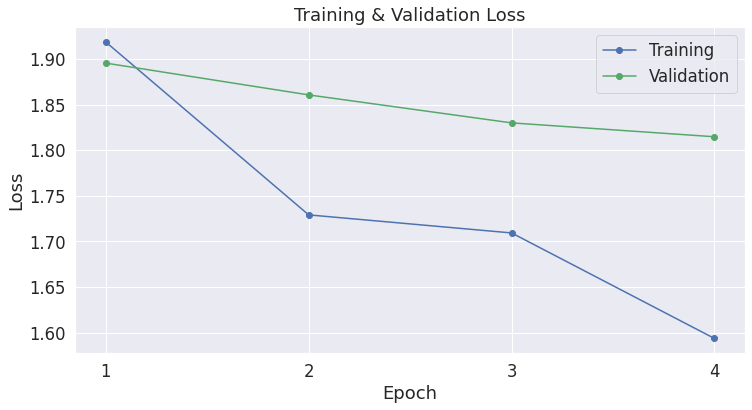

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# 繪圖風格設定
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# 繪製學習曲線
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Val_Loss如果越來越高 代表過擬和

# 模型應用

下面我們載入測試集，並使用 Matthew相關係數來評估模型效能，因為這是一種在 NLP 社群中被廣泛使用的衡量 CoLA 任務效能的方法。使用這種測量方法，+1 為最高分，-1 為最低分。於是，我們就可以在特定任務上，橫向和最好的模型進行效能對比了。

5.1. 資料準備
對測試集的處理，和處理訓練資料集的步驟是一致的，如下

In [ ]:
import pandas as pd

# 載入資料集
# df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df = pd.read_excel("bert_test.xlsx", header=None, names=['sentence_source', 'sentence', 'label'])
# 列印資料集大小
print('Number of test sentences: {:,}\n'.format(df.shape[0]))
# 將資料集轉換為列表
sentences = df.sentence.values
labels = df.label.values

# 分詞、填充或截斷
input_ids = []
attention_masks = []
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        max_length = 64,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

batch_size = 32  

# 準備好資料集
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 21



5.2. 評估測試集效能
準備好測試集資料後，就可以用之前微調的模型來對測試集進行預測了

In [ ]:
# 預測測試集

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
# 依然是評估模式
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# 預測
for batch in prediction_dataloader:
  # 將資料載入到 gpu 中
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  
  # 不需要計算梯度
  with torch.no_grad():
      # 前向傳播，獲取預測結果
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # 將結果載入到 cpu 中
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # 儲存預測結果和 labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('   \n DONE. \n')

print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Predicting labels for 21 test sentences...
   
 DONE. 

Positive samples: 57 of 21 (271.43%)


# 預測結果
正確率 accuracy：在所有情況中，正確判斷真假的比例。

精確率 precision：判斷為真的情況下，有多少是真的真。

召回率 recall：為真的情況下，有多少被正確判斷出來。

FP被還被稱為第一型錯誤(Type 1 Error)，FN被稱為第二型錯誤

In [ ]:
predict_labels_ = [predictions[0][i].tolist().index(max(predictions[0][i])) for i in range(len(predictions[0]))]  # 利用新模型預測出的分類結果
true_labels_ = true_labels[0].tolist()

print(f'利用模型預測出的分類結果： {predict_labels_}')
print(f'真實的分類結果：           {true_labels_}')

利用模型預測出的分類結果： [2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 5, 2, 2, 5, 2]
真實的分類結果：           [0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score



In [ ]:
accuracy = round(accuracy_score(true_labels_, predict_labels_), 4)
precision = round(precision_score(true_labels_, predict_labels_, average = 'micro'), 4)
recall = round(recall_score(true_labels_, predict_labels_, average = 'micro'), 4)


print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')

accuracy: 0.5238
precision: 0.5238
recall: 0.5238


# 混淆矩陣

混淆矩陣是機器學習中總結分類模型預測結果的情形分析表，以矩陣形式將數據集中的記錄按照真實的類別與分類模型預測的類別判斷兩個標準進行匯總。其中矩陣的行表示真實值，矩陣的列表示預測值



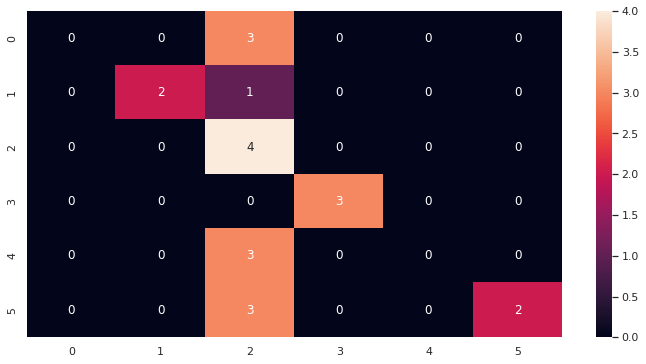

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt 

predict_labels_str = [str(i) for i in predict_labels_]
true_labels_str = [str(i) for i in true_labels_]

sns.set() 

C2= confusion_matrix(true_labels_str, predict_labels_str, labels=["0", "1", "2", '3', '4', '5']) 

sns.heatmap(C2,annot=True)
